# Set up 

In [1]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

# Perturbing enzymes

In [3]:
ant ='../../../models/antimony/TopologyB.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.1363696703589205e-15

In [4]:
pt_levels = [1.5]
pt_labels = ['1.5x']

data_file15 = '../../../data/interim/generated_data/TopologyB-noReg/TopologyB_1.5.csv'

BMCA_obj15 = antemll.antemll(ant, data_file15, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

prior15 = util.run_prior_predictive(BMCA_obj15)

No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


## Running ADVI

In [5]:
def run_ADVI(BMCA_obj, lr=5E-3, tgnc=0.7, onm=1):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=10, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=lr), 
            total_grad_norm_constraint=tgnc,
            obj_n_mc=onm)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(draws=1000, random_seed=SEED)
        ppc_vi = pm.sample_posterior_predictive(trace)

    return trace, ppc_vi

In [6]:
def run_FullRankADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=10, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.FullRankADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(1000)
        ppc_vi = pm.sample_posterior_predictive(trace)

    return trace, ppc_vi


In [7]:
def try_except(run_ADVI, *params):
    try:
        return run_ADVI(*params)
    except:
        pass

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,486.5
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 5,236.4
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,972.7
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,949.4
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,221
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,046.6
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,077.2
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,917
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,990.4
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,834.9
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 17,909
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


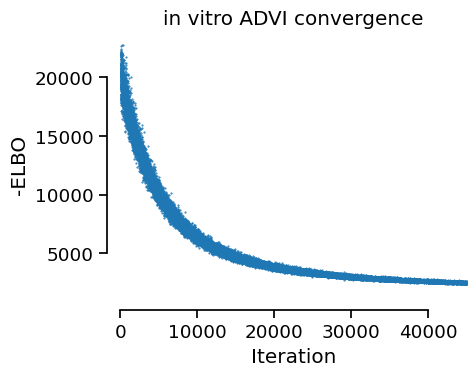

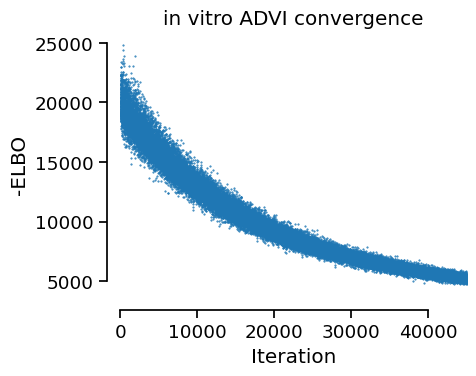

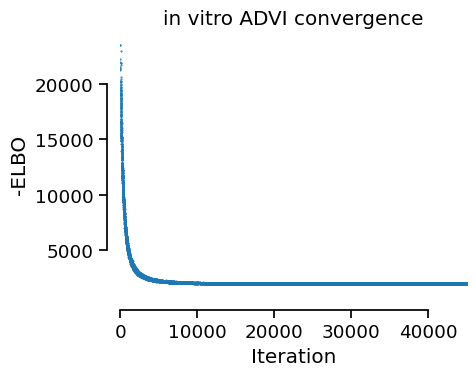

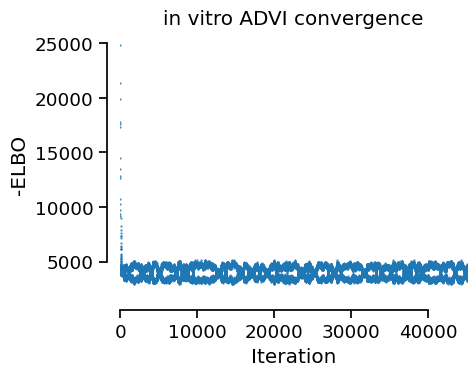

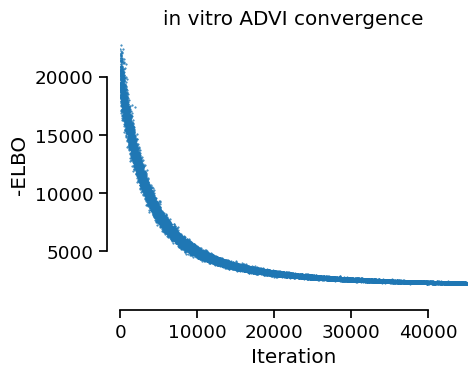

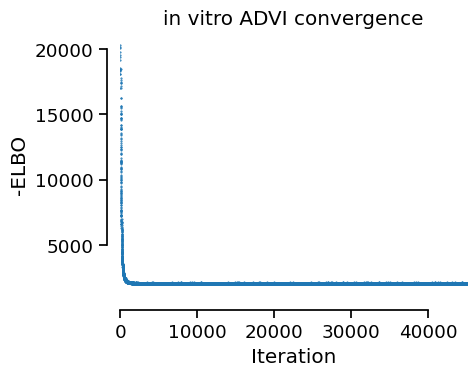

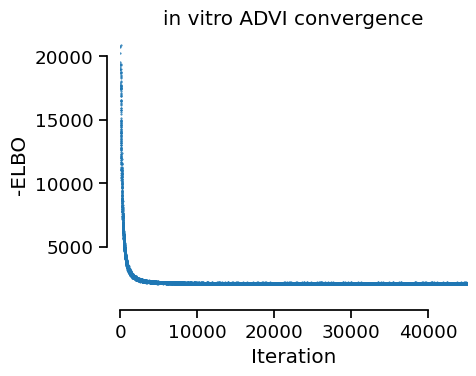

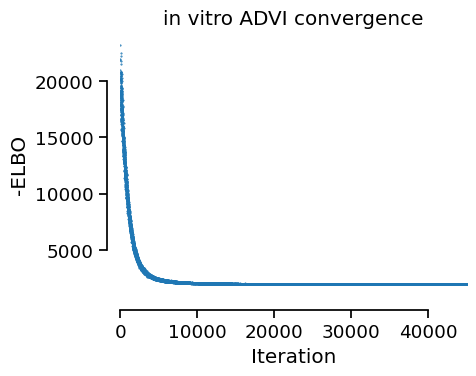

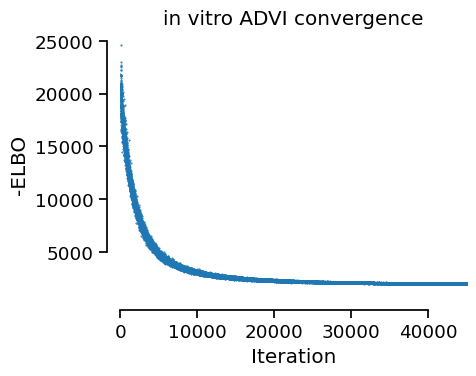

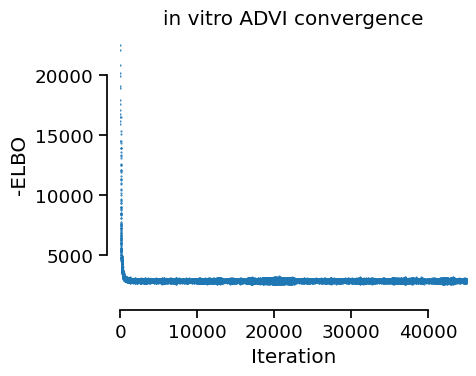

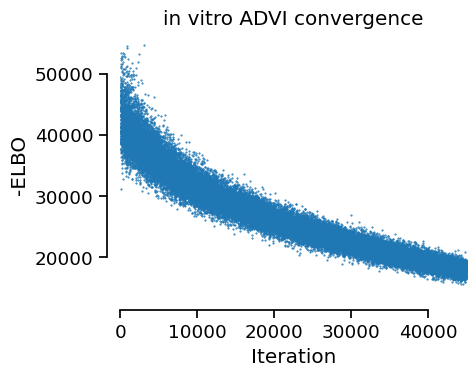

In [8]:
a05, aa05 = try_except(run_ADVI, BMCA_obj15)

b05, bb05 = try_except(run_ADVI, BMCA_obj15, 5E-3, 0.2)
c05, cc05 = try_except(run_ADVI, BMCA_obj15, 0.05, 1)
d05, dd05 = try_except(run_ADVI, BMCA_obj15, 0.5, 10)
e05, ee05 = try_except(run_ADVI, BMCA_obj15, 5E-3, 1)
f05, ff05 = try_except(run_ADVI, BMCA_obj15, 0.05, 10)
g05, gg05 = try_except(run_ADVI, BMCA_obj15, 0.5, 0.2)
h05, hh05 = try_except(run_ADVI, BMCA_obj15, 5E-3, 10)
i05, ii05 = try_except(run_ADVI, BMCA_obj15, 0.05, 0.2)
j05, jj05 = try_except(run_ADVI, BMCA_obj15, 0.5, 1)


k05, kk05 = try_except(run_FullRankADVI, BMCA_obj15)


In [9]:
single_var=[a05, b05, c05, d05, e05, f05, g05, h05, i05, j05, k05]
single_var_names=["a05", "b05", "c05", "d05", "e05", "f05", "g05", "h05", "i05", "j05", "k05"]
double_var=[aa05, bb05, cc05, dd05, ee05, ff05, gg05, hh05, ii05, jj05, kk05]
double_var_names=["aa05", "bb05", "cc05", "dd05", "ee05", "ff05", "gg05", "hh05", "ii05", "jj05", "kk05"]

In [10]:
jar = {}
for i, tr in enumerate(single_var):
    try: 
        jar[single_var_names[i]]=tr
        jar[double_var_names[i]]=double_var[i]
    except:
        pass


### saving trace data

In [11]:
with gzip.open("topologyB-noReg-hptuning15.pgz", "wb") as f:
            cloudpickle.dump(
                jar,
                f,
            )

# Analysis

In [7]:
picklefolder = '../../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyB-noReg-hptuning15.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [8]:
a05 = traces['a05']
aa05 = traces['aa05']
b05 = traces['b05']
bb05 = traces['bb05']
c05 = traces['c05']
cc05 = traces['cc05']
d05 = traces['d05']
dd05 = traces['dd05']
e05 = traces['e05']
ee05 = traces['ee05']
f05 = traces['f05']
ff05 = traces['ff05']
g05 = traces['g05']
gg05 = traces['gg05']
h05 = traces['h05']
hh05 = traces['hh05']
i05 = traces['i05']
ii05 = traces['ii05']
j05 = traces['j05']
jj05 = traces['jj05']
k05 = traces['k05']
kk05 = traces['kk05']

In [9]:
single_var=[a05, b05, c05, d05, e05, f05, g05, h05, i05, j05, k05]
single_var_names=["a05", "b05", "c05", "d05", "e05", "f05", "g05", "h05", "i05", "j05", "k05"]
double_var=[aa05, bb05, cc05, dd05, ee05, ff05, gg05, hh05, ii05, jj05, kk05]
double_var_names=["aa05", "bb05", "cc05", "dd05", "ee05", "ff05", "gg05", "hh05", "ii05", "jj05", "kk05"]

In [10]:
v_ppc_aa05 = az.summary(aa05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_bb05 = az.summary(bb05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_cc05 = az.summary(cc05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_dd05 = az.summary(dd05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_ee05 = az.summary(ee05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_ff05 = az.summary(ff05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_gg05 = az.summary(gg05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_hh05 = az.summary(hh05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_ii05 = az.summary(ii05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_jj05 = az.summary(jj05['posterior_predictive']['v_hat_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [11]:
x_ppc_aa05 = az.summary(aa05['posterior_predictive']['chi_obs'])['mean']
x_ppc_bb05 = az.summary(bb05['posterior_predictive']['chi_obs'])['mean']
x_ppc_cc05 = az.summary(cc05['posterior_predictive']['chi_obs'])['mean']
x_ppc_dd05 = az.summary(dd05['posterior_predictive']['chi_obs'])['mean']
x_ppc_ee05 = az.summary(ee05['posterior_predictive']['chi_obs'])['mean']
x_ppc_ff05 = az.summary(ff05['posterior_predictive']['chi_obs'])['mean']
x_ppc_gg05 = az.summary(gg05['posterior_predictive']['chi_obs'])['mean']
x_ppc_hh05 = az.summary(hh05['posterior_predictive']['chi_obs'])['mean']
x_ppc_ii05 = az.summary(ii05['posterior_predictive']['chi_obs'])['mean']
x_ppc_jj05 = az.summary(jj05['posterior_predictive']['chi_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [12]:
e_ppc_aa05 = az.summary(aa05['posterior_predictive']['e_obs'])['mean']
e_ppc_bb05 = az.summary(bb05['posterior_predictive']['e_obs'])['mean']
e_ppc_cc05 = az.summary(cc05['posterior_predictive']['e_obs'])['mean']
e_ppc_dd05 = az.summary(dd05['posterior_predictive']['e_obs'])['mean']
e_ppc_ee05 = az.summary(ee05['posterior_predictive']['e_obs'])['mean']
e_ppc_ff05 = az.summary(ff05['posterior_predictive']['e_obs'])['mean']
e_ppc_gg05 = az.summary(gg05['posterior_predictive']['e_obs'])['mean']
e_ppc_hh05 = az.summary(hh05['posterior_predictive']['e_obs'])['mean']
e_ppc_ii05 = az.summary(ii05['posterior_predictive']['e_obs'])['mean']
e_ppc_jj05 = az.summary(jj05['posterior_predictive']['e_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [13]:
v_ppcs = [v_ppc_aa05, v_ppc_bb05, v_ppc_cc05, v_ppc_dd05, v_ppc_ee05, v_ppc_ff05, v_ppc_gg05, v_ppc_hh05, v_ppc_ii05, v_ppc_jj05]
x_ppcs = [x_ppc_aa05, x_ppc_bb05, x_ppc_cc05, x_ppc_dd05, x_ppc_ee05, x_ppc_ff05, x_ppc_gg05, x_ppc_hh05, x_ppc_ii05, x_ppc_jj05]
e_ppcs = [e_ppc_aa05, e_ppc_bb05, e_ppc_cc05, e_ppc_dd05, e_ppc_ee05, e_ppc_ff05, e_ppc_gg05, e_ppc_hh05, e_ppc_ii05, e_ppc_jj05]

In [25]:
for ppc in v_ppcs:
    print(np.sum(abs(BMCA_obj15.vn.values - ppc.values.reshape((19,-1)).T))/(20*19))


4.171268589684142
4.221399193359476
3.910738309638868
4.32858795955623
3.953973155690631
4.312458270349226
4.059158195501265
4.275770459207181
4.103647523642435
4.379119869598666


In [27]:
for ppc in x_ppcs:
    print(np.sum(abs(BMCA_obj15.xn.values - ppc.values.reshape((13,-1)).T))/(20*13))


0.2632807122820493
0.2784499992699728
0.2910014708584029
0.25315873326765814
0.2902086063287979
0.2876819038918319
0.28792453942067375
0.2874783251395436
0.2758032050583768
0.2837914350985891


#### Known flux and metabolite concentrations check

Text(0.5, 0.98, 'BMCA on Topology B, 1.5x pt, allData')

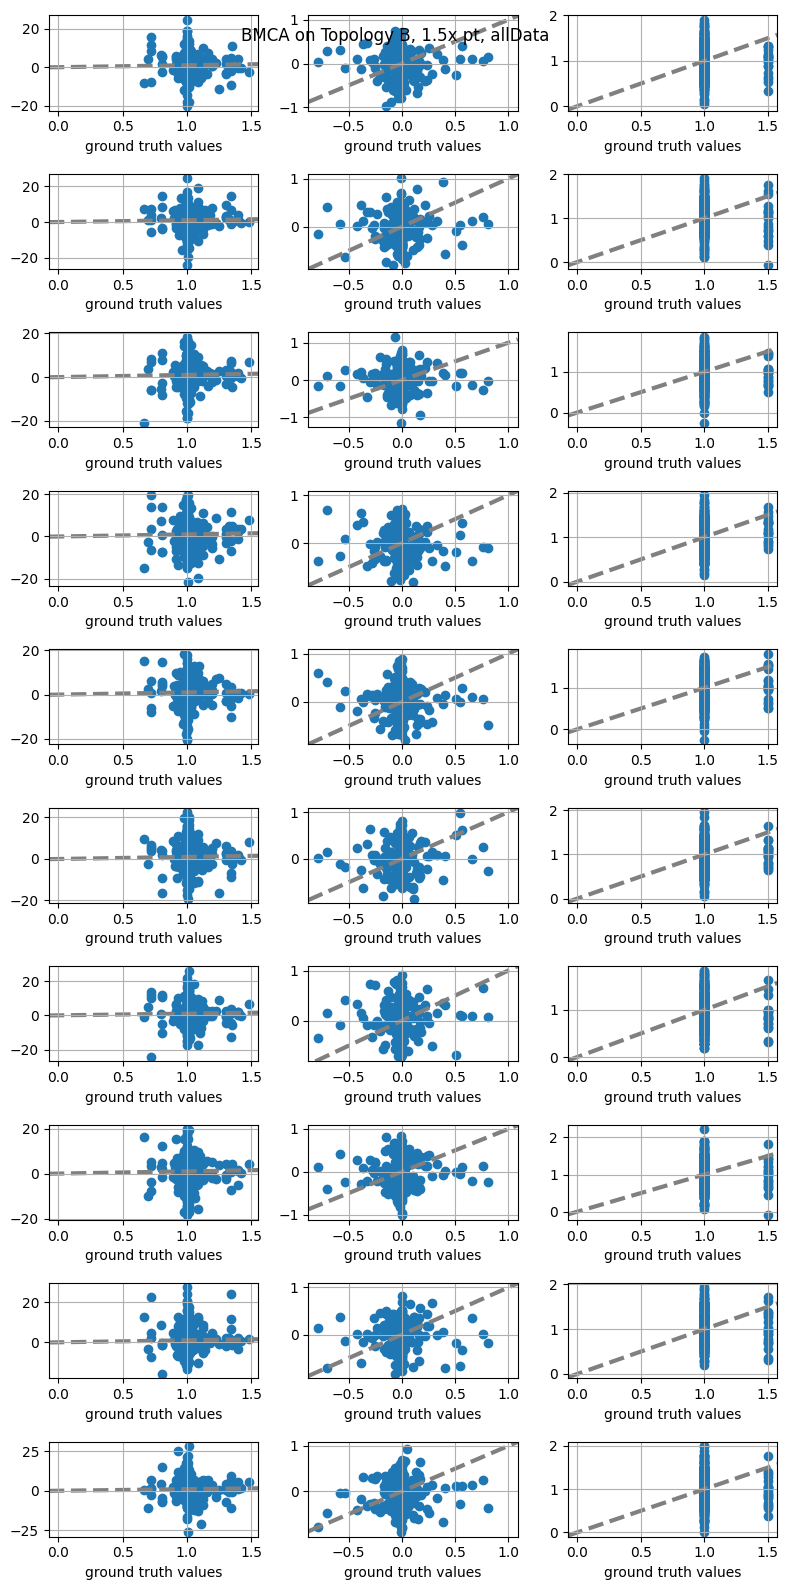

In [12]:
# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(10, 3, figsize=(8,16))

for i in range(10):

    # ax[i,0].set_aspect('equal', 'datalim')
    ax[i,0].scatter(BMCA_obj15.vn.values, v_ppcs[i].values.reshape((19,-1)))
    ax[i,0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,0].set_title('v_obs, ground truth vs. posterior predictive')
    ax[i,0].set_xlabel('ground truth values')
    # ax[i,0].set_ylabel('predicted values')
    ax[i,0].grid()

    # ax[i,1].set_aspect('equal', 'datalim')
    ax[i,1].scatter(BMCA_obj15.xn.values, x_ppcs[i].values.reshape((13,-1)))
    ax[i,1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,1].set_title('chi_obs, ground truth vs. posterior predictive')
    ax[i,1].set_xlabel('ground truth values')
    ax[i,1].grid()

    # ax[i,2].set_aspect('equal', 'datalim')
    ax[i,2].scatter(BMCA_obj15.en.values, e_ppcs[i].values.reshape((19,-1)))
    ax[i,2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,2].set_title('e_obs, ground truth vs. posterior predictive')
    ax[i,2].set_xlabel('ground truth values')
    ax[i,2].grid()


f.tight_layout()

f.suptitle('BMCA on Topology B, 1.5x pt, allData')

#### Elasticity check

In [13]:
Ex_a = util.get_az_summary(a05)
Ex_b = util.get_az_summary(b05)
Ex_c = util.get_az_summary(c05)
Ex_d = util.get_az_summary(d05)
Ex_e = util.get_az_summary(e05)
Ex_f = util.get_az_summary(f05)
Ex_g = util.get_az_summary(g05)
Ex_h = util.get_az_summary(h05)
Ex_i = util.get_az_summary(i05)
Ex_j = util.get_az_summary(j05)
Ex_k = util.get_az_summary(k05)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [14]:
prior_Ex05_advi = az.summary(prior15['prior']['Ex'])['mean']

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [15]:
pt_labels= ['1.5x-pr'] + single_var_names

In [16]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                prior_Ex05_advi, Ex_a,Ex_b, Ex_c, Ex_d, Ex_e, Ex_f, Ex_g, Ex_h, Ex_i, Ex_j, Ex_k])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyB_allData_elasticities.csv')

In [17]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

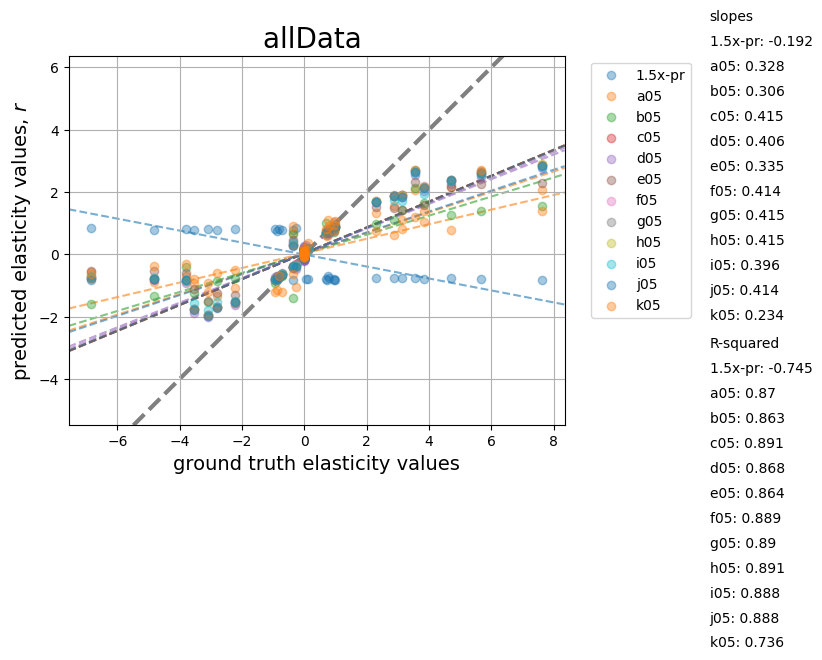

In [46]:
## Elasticities, comparison of prior and post 
#plt.ylim(-10,10)
#plt.xlim(-10,10)
plt.axes().set_aspect('equal', 'datalim')

for label in pt_labels: 
    plt.scatter(elasticities_df['gt'], elasticities_df[label], alpha=0.4, label=label, zorder=10)


plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData ', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 13
line_spacing = 0.8
slope_start = 7.5
r2_start = -3# slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']*3
for i in range(len(e_slopes)):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)


In [19]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()/len(elasticities_df['gt'])
MAE

gt         0.000000
1.5x-pr    0.386686
a05        0.173526
b05        0.190169
c05        0.147888
d05        0.235225
e05        0.168627
f05        0.151918
g05        0.151823
h05        0.143697
i05        0.151013
j05        0.182125
k05        0.236123
dtype: float64

## Calculating FCCs

In [20]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

### Negative predictions

In [21]:
Ex05_prior = util.get_az_summary(prior15['prior']['Ex'])


arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [22]:
priorFCC05 = util.estimate_CCs(BMCA_obj15, Ex05_prior.reshape((19,-1)))

postFCC_a05 = util.estimate_CCs(BMCA_obj15, Ex_a.reshape((19,-1)))
postFCC_b05 = util.estimate_CCs(BMCA_obj15, Ex_b.reshape((19,-1)))
postFCC_c05 = util.estimate_CCs(BMCA_obj15, Ex_c.reshape((19,-1)))
postFCC_d05 = util.estimate_CCs(BMCA_obj15, Ex_d.reshape((19,-1)))
postFCC_e05 = util.estimate_CCs(BMCA_obj15, Ex_e.reshape((19,-1)))
postFCC_f05 = util.estimate_CCs(BMCA_obj15, Ex_f.reshape((19,-1)))
postFCC_g05 = util.estimate_CCs(BMCA_obj15, Ex_g.reshape((19,-1)))
postFCC_h05 = util.estimate_CCs(BMCA_obj15, Ex_h.reshape((19,-1)))
postFCC_i05 = util.estimate_CCs(BMCA_obj15, Ex_i.reshape((19,-1)))
postFCC_j05 = util.estimate_CCs(BMCA_obj15, Ex_j.reshape((19,-1)))
postFCC_k05 = util.estimate_CCs(BMCA_obj15, Ex_k.reshape((19,-1)))

In [23]:
prior_FCCs = [priorFCC05]
post_FCCs = [postFCC_a05, postFCC_b05, postFCC_c05, postFCC_d05, postFCC_e05, postFCC_f05, postFCC_g05, postFCC_h05, postFCC_i05, postFCC_j05, postFCC_k05]


In [25]:
prd_priorFCCs = pd.concat([util.append_FCC_df(prior_FCCs[i], pt_labels[i],r) for i in range(len(prior_FCCs))])
prd_postFCCs = pd.concat([util.append_FCC_df(post_FCCs[i], pt_labels[i],r) for i in range(len(post_FCCs))])

## Evaluating FCC ranking

In [26]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['v19']

### via Spearman rank coefficients

In [28]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v19',r)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = util.bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [29]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
1.5x-pr,0.195046,4.379864e-01,-0.364036,0.670147
a05,0.894737,5.422111e-07,0.655798,0.987422
b05,0.593395,9.432615e-03,0.082561,0.904269
c05,0.896801,4.658861e-07,0.635836,0.985387
d05,0.566563,1.422682e-02,0.090696,0.848075
e05,0.923633,4.568457e-08,0.716622,0.993684
f05,0.715170,8.492396e-04,0.278238,0.926842
g05,0.785346,1.126543e-04,0.390219,0.943809
h05,0.931889,1.878288e-08,0.757302,0.987500
i05,0.907121,2.073699e-07,0.727599,0.981318


In [30]:
# spearman_df.to_csv('../../../data/results/spearman_coefficients/topologyB-noReg-hptuning15_spr.csv')


(0.0, 1.05)

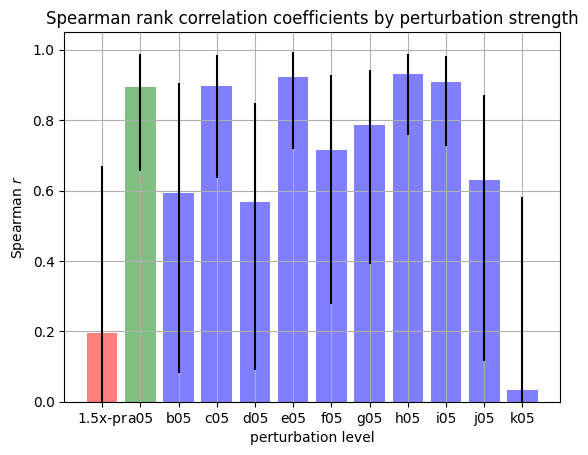

In [32]:
plt.bar(pt_labels, [i for i in spearman_coefficients], alpha=0.5, color=['r']+['g']+['b']*10)
plt.grid()

for i, txt in enumerate(spearman_df['r']):
    plt.vlines(pt_labels[i], spearman_df['lower'][i], spearman_df['upper'][i], color='k')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

### evaluating top 10 rankings

In [34]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v19', r)
    b_list.append(b)

ranked_b_list = [b.sort_values().reset_index().set_index('v19') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('v19')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q.head(15) ## top 15 table

,gt,1.5x-pr,a05,b05,c05,d05,e05,f05,g05,h05,i05,j05,k05
v19,,,,,,,,,,,,,
1.0,v18,v18,v18,v18,v18,v5,v18,v18,v1,v18,v18,v1,v18
2.0,v1,v15,v1,v15,v1,v9,v14,v14,v18,v14,v1,v7,v15
3.0,v14,v16,v14,v1,v7,v18,v1,v1,v7,v7,v7,v4,v14
4.0,v7,v14,v7,v7,v14,v7,v7,v7,v14,v1,v14,v18,v5
5.0,v4,v17,v5,v14,v4,v8,v4,v4,v3,v4,v3,v14,v8
6.0,v5,v8,v4,v5,v5,v4,v5,v10,v4,v5,v4,v2,v16
7.0,v12,v4,v8,v4,v12,v2,v8,v8,v12,v9,v5,v9,v10
8.0,v3,v1,v15,v8,v15,v3,v15,v9,v2,v8,v9,v12,v13
9.0,v9,v5,v9,v16,v3,v1,v12,v5,v11,v15,v8,v11,v17


In [35]:
q.to_csv('../../../data/results/rankings/topologyB-noReg-hptuning15_rankings.csv')

In [36]:
rank_df = pd.read_csv('../../../data/results/rankings/topologyB-noReg-hptuning15_rankings.csv')

In [37]:
topTen_df = rank_df[rank_df['v19'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results ## number of correct predictions of top 10 FCC values 

,1.5x-pr,a05,b05,c05,d05,e05,f05,g05,h05,i05,j05,k05
0,6,9,7,8,8,9,8,8,9,10,8,5


In [38]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)

Int64Index([13, 14, 15, 16], dtype='int64')
Int64Index([13], dtype='int64')
Int64Index([13, 14, 16], dtype='int64')
Int64Index([11, 13], dtype='int64')
Int64Index([10, 17], dtype='int64')
Int64Index([13], dtype='int64')
Int64Index([12, 15], dtype='int64')
Int64Index([11, 17], dtype='int64')
Int64Index([13], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([11, 17], dtype='int64')
Int64Index([10, 12, 13, 14, 16], dtype='int64')
